# Importing Libraries

In [1]:
import pandas as pd
from sklearn.feature_extraction import FeatureHasher
import numpy as np
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Getting data

In [2]:
a=0
df = pd.DataFrame()

for i in range(12):
    a+=1
    df1 = pd.read_csv('/kaggle/input/dataaa/pucon24_ai_train_'+str(a)+'.csv')
    df = pd.concat([df, df1])


# Convert date into proper format

In [3]:
df['Date']

0       2009-01-02-00:00:00
1       2009-01-02-00:00:00
2       2009-01-02-00:00:00
3       2009-01-02-00:00:00
4       02-01-2009-00:00:00
               ...         
3947    2022-12-31-00:00:00
3948    31-12-2022-00:00:00
3949    2022-12-31-00:00:00
3950    31-12-2022-00:00:00
3951    31-12-2022-00:00:00
Name: Date, Length: 553952, dtype: object

In [4]:
df['Date'] = pd.to_datetime(df['Date'],format='mixed')

# Convert all dates back to the desired format (e.g., MM-DD-YYYY)
df['Date'] = df['Date'].dt.strftime('%m-%d-%Y')
df['Date'] = pd.to_datetime(df['Date'],format='mixed')
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Date']

0      2009-01-02
1      2009-01-02
2      2009-01-02
3      2009-01-02
4      2009-02-01
          ...    
3947   2022-12-31
3948   2022-12-31
3949   2022-12-31
3950   2022-12-31
3951   2022-12-31
Name: Date, Length: 553952, dtype: datetime64[ns]

 # Reasoning that estimated value and sale price cannot be zero so will remove these rows later

In [5]:

df[df['Estimated Value']==0].isna().sum()

Date                              0
crime_rate                       46
renovation_level                  0
Year                              0
Address                           0
num_rooms                         0
Property                          0
amenities_rating                  0
carpet_area                      15
nearby_restaurants                0
public_transport_availability     0
property_tax_rate                31
distance_to_school                0
Locality                          0
Residential                       0
Estimated Value                   0
Sale Price                        0
specifications                    0
Month                             0
Day                               0
dtype: int64

# Converting some categorical features to numerical based on domain knowledge

In [6]:
df['num_rooms'] = np.where(df['num_rooms']=='Two rooms',2,df['num_rooms'])
df['num_rooms'] = np.where(df['num_rooms']=='Three rooms',3,df['num_rooms'])
df['num_rooms'] = np.where(df['num_rooms']=='Six rooms',6,df['num_rooms'])
df['num_rooms'] = np.where(df['num_rooms']=='Four rooms',4,df['num_rooms'])
df['num_rooms'] = np.where(df['num_rooms']=='Eight rooms',8,df['num_rooms'])


df['amenities_rating'] = np.where(df['amenities_rating']=='Below Average',2,df['amenities_rating'])
df['amenities_rating'] = np.where(df['amenities_rating']=='Marginal',1,df['amenities_rating'])
df['amenities_rating'] = np.where(df['amenities_rating']=='Unimpressive',3,df['amenities_rating'])
df['amenities_rating'] = np.where(df['amenities_rating']=='Commonplace',3,df['amenities_rating'])
df['amenities_rating'] = np.where(df['amenities_rating']=='Mediocre',3,df['amenities_rating'])
df['amenities_rating'] = np.where(df['amenities_rating']=='Satisfactory',4,df['amenities_rating'])
df['amenities_rating'] = np.where(df['amenities_rating']=='Outstanding',5,df['amenities_rating'])
df['amenities_rating'] = np.where(df['amenities_rating']=='Superb',5,df['amenities_rating'])
df['amenities_rating'] = np.where(df['amenities_rating']=='Exceptional',5,df['amenities_rating'])
df['amenities_rating'] = np.where(df['amenities_rating']=='Luxurious',6,df['amenities_rating'])

df['public_transport_availability'] = np.where(df['public_transport_availability']=='Insufficient',1,df['public_transport_availability'])
df['public_transport_availability'] = np.where(df['public_transport_availability']=='Inadequate',1,df['public_transport_availability'])
df['public_transport_availability'] = np.where(df['public_transport_availability']=='Sparse',2,df['public_transport_availability'])
df['public_transport_availability'] = np.where(df['public_transport_availability']=='Patchy',2,df['public_transport_availability'])
df['public_transport_availability'] = np.where(df['public_transport_availability']=='Limited',2,df['public_transport_availability'])
df['public_transport_availability'] = np.where(df['public_transport_availability']=='Scattered',2,df['public_transport_availability'])
df['public_transport_availability'] = np.where(df['public_transport_availability']=='Accessible',3,df['public_transport_availability'])
df['public_transport_availability'] = np.where(df['public_transport_availability']=='Well-connected',4,df['public_transport_availability'])
df['public_transport_availability'] = np.where(df['public_transport_availability']=='Extensive',4,df['public_transport_availability'])
df['public_transport_availability'] = np.where(df['public_transport_availability']=='Abundant',4,df['public_transport_availability'])

df['renovation_level'] = np.where(df['renovation_level']=='Minor',1,df['renovation_level'])
df['renovation_level'] = np.where(df['renovation_level']=='Essential',2,df['renovation_level'])
df['renovation_level'] = np.where(df['renovation_level']=='Partial',3,df['renovation_level'])
df['renovation_level'] = np.where(df['renovation_level']=='Limited',3,df['renovation_level'])
df['renovation_level'] = np.where(df['renovation_level']=='Basic',4,df['renovation_level'])
df['renovation_level'] = np.where(df['renovation_level']=='Standard',5,df['renovation_level'])
df['renovation_level'] = np.where(df['renovation_level']=='Advanced',6,df['renovation_level'])
df['renovation_level'] = np.where(df['renovation_level']=='Complete',7,df['renovation_level'])
df['renovation_level'] = np.where(df['renovation_level']=='Extensive',7,df['renovation_level'])
df['renovation_level'] = np.where(df['renovation_level']=='Premium',7,df['renovation_level'])

df

,Date,crime_rate,renovation_level,Year,Address,num_rooms,Property,amenities_rating,carpet_area,nearby_restaurants,public_transport_availability,property_tax_rate,distance_to_school,Locality,Residential,Estimated Value,Sale Price,specifications,Month,Day
0,2009-01-02,2.6568262407789027,1,2009,40 ETTL LN UT 24,2,Condo,3,760.0,19.0,2,1.025953,6.586707,Greenwich,Condominium,711270.0,975000.0,"In 2009, this condo located in Greenwich at 40...",1,2
1,2009-01-02,5.328727031244374,4,2009,18 BAUER RD,3,Single Family,5,7967.337677159014,17.0,4,1.025953,8.224127,East Hampton,Detached House,119970.0,189900.0,"In 2009, this single family located in East Ha...",1,2
2,2009-01-02,4.037758682930219,4,2009,48 HIGH VALLEY RD.,3,Single Family,4,982.0,1.0,3,1.025953,8.019369,Ridgefield,Detached House,494530.0,825000.0,"In 2009, this single family located in Ridgefi...",1,2
3,2009-01-02,2.085308997846847,7,2009,56 MERIDEN RD,3,Single Family,5,976.0,5.0,1,1.025953,6.175522,Old Lyme,Detached House,197600.0,450000.0,"In 2009, this single family located in Old Lym...",1,2
4,2009-02-01,4.397712193695299,3,2009,13 CELENTANO DR,3,Single Family,2,947.0,14.0,1,NaN,1.677037,Naugatuck,Detached House,105440.0,200000.0,"In 2009, this single family located in Naugatu...",2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,2022-12-31,NaN,1,2022,50 SWORD AVE,3,Residential,5,1009.0,12.0,3,1.003979,3.174853,Enfield,Detached House,122420.0,198000.0,"In 2022, this residential located in Enfield a...",12,31
3948,2022-12-31,1.6188621542259798,7,2022,10 ROLLINGWOOD DR,3,Residential,5,999.0,12.0,2,1.003979,2.241818,Naugatuck,Detached House,139180.0,319900.0,"In 2022, this residential located in Naugatuck...",12,31
3949,2022-12-31,6.101211958266304,7,2022,189 PALMER DR,3,Residential,4,1017.0,7.0,2,1.003979,6.686049,South Windsor,Detached House,200000.0,305000.0,"In 2022, this residential located in South Win...",12,31
3950,2022-12-31,4.572265207685737,1,2022,33 BURNWOOD DRIVE,3,Residential,2,1061.0,12.0,4,1.003979,3.974339,Bloomfield,Detached House,195440.0,271000.0,"In 2022, this residential located in Bloomfiel...",12,31


# Target Encoding locating and address as they cannot be encoded normally

Catboost encoding didnt work well so using target encoding

In [ ]:
'''
import category_encoders as ce 

cbe_encoder = ce.cat_boost.CatBoostEncoder() 
  
# Fit encoder and transform the features 
cbe_encoder.fit(df['Locality'], df['Sale Price'])

df['Locality'] = cbe_encoder.transform(df['Locality'])

cbe_encoder.fit(df['Address'], df['Sale Price'])
df['Address'] = cbe_encoder.transform(df['Address'])

df'''

In [7]:
target_encoder1 = TargetEncoder()

# Fit the TargetEncoder to the data
target_encoder1.fit(df['Locality'], df['Sale Price'])

# Transform the 'Category' column using target encoding
df['Locality'] = target_encoder1.transform(df['Locality'], df['Sale Price'])


In [9]:
def remove_numbers(address):
    return re.sub(r'\d+', '', address)
import re
# Apply the function to the 'Address' column
df['Address'] = df['Address'].apply(remove_numbers)
target_encoder = TargetEncoder()
target_encoder.fit(df['Address'], df['Sale Price'])

df['Address'] = target_encoder.transform(df['Address'], df['Sale Price'])
df

,Date,crime_rate,renovation_level,Year,Address,num_rooms,Property,amenities_rating,carpet_area,nearby_restaurants,public_transport_availability,property_tax_rate,distance_to_school,Locality,Residential,Estimated Value,Sale Price,specifications,Month,Day
0,2009-01-02,2.6568262407789027,1,2009,437982.278825,2,Condo,3,760.0,19.0,2,1.025953,6.586707,2.049257e+06,Condominium,711270.0,975000.0,"In 2009, this condo located in Greenwich at 40...",1,2
1,2009-01-02,5.328727031244374,4,2009,324633.999414,3,Single Family,5,7967.337677159014,17.0,4,1.025953,8.224127,2.458458e+05,Detached House,119970.0,189900.0,"In 2009, this single family located in East Ha...",1,2
2,2009-01-02,4.037758682930219,4,2009,413077.661015,3,Single Family,4,982.0,1.0,3,1.025953,8.019369,6.981581e+05,Detached House,494530.0,825000.0,"In 2009, this single family located in Ridgefi...",1,2
3,2009-01-02,2.085308997846847,7,2009,139439.177332,3,Single Family,5,976.0,5.0,1,1.025953,6.175522,4.049013e+05,Detached House,197600.0,450000.0,"In 2009, this single family located in Old Lym...",1,2
4,2009-02-01,4.397712193695299,3,2009,180710.893038,3,Single Family,2,947.0,14.0,1,NaN,1.677037,1.710457e+05,Detached House,105440.0,200000.0,"In 2009, this single family located in Naugatu...",2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,2022-12-31,NaN,1,2022,221444.365437,3,Residential,5,1009.0,12.0,3,1.003979,3.174853,1.794088e+05,Detached House,122420.0,198000.0,"In 2022, this residential located in Enfield a...",12,31
3948,2022-12-31,1.6188621542259798,7,2022,256196.862632,3,Residential,5,999.0,12.0,2,1.003979,2.241818,1.710457e+05,Detached House,139180.0,319900.0,"In 2022, this residential located in Naugatuck...",12,31
3949,2022-12-31,6.101211958266304,7,2022,319806.002773,3,Residential,4,1017.0,7.0,2,1.003979,6.686049,2.582401e+05,Detached House,200000.0,305000.0,"In 2022, this residential located in South Win...",12,31
3950,2022-12-31,4.572265207685737,1,2022,337904.902927,3,Residential,2,1061.0,12.0,4,1.003979,3.974339,2.326527e+05,Detached House,195440.0,271000.0,"In 2022, this residential located in Bloomfiel...",12,31


# Exploratory Data Analysis

In [10]:
df['Is_residential']= np.where(df['Property']=='Residential',1,0)

df.drop(columns=['Property','specifications','Date','Residential'],inplace=True)
df

,crime_rate,renovation_level,Year,Address,num_rooms,amenities_rating,carpet_area,nearby_restaurants,public_transport_availability,property_tax_rate,distance_to_school,Locality,Estimated Value,Sale Price,Month,Day,Is_residential
0,2.6568262407789027,1,2009,437982.278825,2,3,760.0,19.0,2,1.025953,6.586707,2.049257e+06,711270.0,975000.0,1,2,0
1,5.328727031244374,4,2009,324633.999414,3,5,7967.337677159014,17.0,4,1.025953,8.224127,2.458458e+05,119970.0,189900.0,1,2,0
2,4.037758682930219,4,2009,413077.661015,3,4,982.0,1.0,3,1.025953,8.019369,6.981581e+05,494530.0,825000.0,1,2,0
3,2.085308997846847,7,2009,139439.177332,3,5,976.0,5.0,1,1.025953,6.175522,4.049013e+05,197600.0,450000.0,1,2,0
4,4.397712193695299,3,2009,180710.893038,3,2,947.0,14.0,1,NaN,1.677037,1.710457e+05,105440.0,200000.0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,NaN,1,2022,221444.365437,3,5,1009.0,12.0,3,1.003979,3.174853,1.794088e+05,122420.0,198000.0,12,31,1
3948,1.6188621542259798,7,2022,256196.862632,3,5,999.0,12.0,2,1.003979,2.241818,1.710457e+05,139180.0,319900.0,12,31,1
3949,6.101211958266304,7,2022,319806.002773,3,4,1017.0,7.0,2,1.003979,6.686049,2.582401e+05,200000.0,305000.0,12,31,1
3950,4.572265207685737,1,2022,337904.902927,3,2,1061.0,12.0,4,1.003979,3.974339,2.326527e+05,195440.0,271000.0,12,31,1


In [11]:
df.replace('Not Provided', np.nan, inplace=True)

df.isna().sum()

crime_rate                       22184
renovation_level                     0
Year                                 0
Address                              0
num_rooms                            0
amenities_rating                     0
carpet_area                       5404
nearby_restaurants                   0
public_transport_availability        0
property_tax_rate                11230
distance_to_school                   0
Locality                             0
Estimated Value                      0
Sale Price                           0
Month                                0
Day                                  0
Is_residential                       0
dtype: int64

# Handling Missing Values

In [12]:
#Didnt use KNN because of Time Complexity
imputer = SimpleImputer(strategy='mean')  # You can use other strategies like 'median', 'most_frequent', etc.

# Fit the imputer on the training data and transform both training and validation sets
dfx= imputer.fit_transform(df)

# Impute missing values

# Convert the result back to a DataFrame
df = pd.DataFrame(dfx, columns=df.columns)
df

,crime_rate,renovation_level,Year,Address,num_rooms,amenities_rating,carpet_area,nearby_restaurants,public_transport_availability,property_tax_rate,distance_to_school,Locality,Estimated Value,Sale Price,Month,Day,Is_residential
0,2.656826,1.0,2009.0,437982.278825,2.0,3.0,760.000000,19.0,2.0,1.025953,6.586707,2.049257e+06,711270.0,975000.0,1.0,2.0,0.0
1,5.328727,4.0,2009.0,324633.999414,3.0,5.0,7967.337677,17.0,4.0,1.025953,8.224127,2.458458e+05,119970.0,189900.0,1.0,2.0,0.0
2,4.037759,4.0,2009.0,413077.661015,3.0,4.0,982.000000,1.0,3.0,1.025953,8.019369,6.981581e+05,494530.0,825000.0,1.0,2.0,0.0
3,2.085309,7.0,2009.0,139439.177332,3.0,5.0,976.000000,5.0,1.0,1.025953,6.175522,4.049013e+05,197600.0,450000.0,1.0,2.0,0.0
4,4.397712,3.0,2009.0,180710.893038,3.0,2.0,947.000000,14.0,1.0,1.301160,1.677037,1.710457e+05,105440.0,200000.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553947,5.360850,1.0,2022.0,221444.365437,3.0,5.0,1009.000000,12.0,3.0,1.003979,3.174853,1.794088e+05,122420.0,198000.0,12.0,31.0,1.0
553948,1.618862,7.0,2022.0,256196.862632,3.0,5.0,999.000000,12.0,2.0,1.003979,2.241818,1.710457e+05,139180.0,319900.0,12.0,31.0,1.0
553949,6.101212,7.0,2022.0,319806.002773,3.0,4.0,1017.000000,7.0,2.0,1.003979,6.686049,2.582401e+05,200000.0,305000.0,12.0,31.0,1.0
553950,4.572265,1.0,2022.0,337904.902927,3.0,2.0,1061.000000,12.0,4.0,1.003979,3.974339,2.326527e+05,195440.0,271000.0,12.0,31.0,1.0


# Removing outliers

In [13]:
ae = df
for col in ['crime_rate','carpet_area','nearby_restaurants','property_tax_rate','distance_to_school','Estimated Value']:
    Q1 = ae[col].quantile(0.25)
    Q3 = ae[col].quantile(0.75)

# Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

# Filter out the rows containing outliers
    ae = ae[(ae[col] >= lower_bound) & (ae[col] <= upper_bound)]
ae

,crime_rate,renovation_level,Year,Address,num_rooms,amenities_rating,carpet_area,nearby_restaurants,public_transport_availability,property_tax_rate,distance_to_school,Locality,Estimated Value,Sale Price,Month,Day,Is_residential
2,4.037759,4.0,2009.0,413077.661015,3.0,4.0,982.0,1.0,3.0,1.025953,8.019369,698158.052632,494530.0,825000.0,1.0,2.0,0.0
3,2.085309,7.0,2009.0,139439.177332,3.0,5.0,976.0,5.0,1.0,1.025953,6.175522,404901.346719,197600.0,450000.0,1.0,2.0,0.0
4,4.397712,3.0,2009.0,180710.893038,3.0,2.0,947.0,14.0,1.0,1.301160,1.677037,171045.696239,105440.0,200000.0,2.0,1.0,0.0
5,7.240137,1.0,2009.0,207404.914779,3.0,5.0,1084.0,8.0,4.0,1.025953,9.701621,163367.607429,53330.0,70000.0,1.0,2.0,0.0
6,0.463141,3.0,2009.0,268527.986662,3.0,5.0,1082.0,6.0,1.0,1.025953,2.380680,352458.785202,134300.0,330000.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553947,5.360850,1.0,2022.0,221444.365437,3.0,5.0,1009.0,12.0,3.0,1.003979,3.174853,179408.837994,122420.0,198000.0,12.0,31.0,1.0
553948,1.618862,7.0,2022.0,256196.862632,3.0,5.0,999.0,12.0,2.0,1.003979,2.241818,171045.696239,139180.0,319900.0,12.0,31.0,1.0
553949,6.101212,7.0,2022.0,319806.002773,3.0,4.0,1017.0,7.0,2.0,1.003979,6.686049,258240.056695,200000.0,305000.0,12.0,31.0,1.0
553950,4.572265,1.0,2022.0,337904.902927,3.0,2.0,1061.0,12.0,4.0,1.003979,3.974339,232652.697567,195440.0,271000.0,12.0,31.0,1.0


# Handling 0 Estimated Value and Sale Price

In [14]:
ae = ae[ae['Estimated Value']!=0]
ae = ae[ae['Sale Price']!=0]

# Feature Selection Based on model feature importances and tableau visualizations

In [15]:

newdf = ae[['crime_rate',
        'carpet_area',
       'distance_to_school', 'Locality', 'Estimated Value', 'Sale Price',
       'Month']]



In [16]:
y = newdf['Sale Price']
# Separate features and target variable
X = newdf.drop(columns=['Sale Price'])
# Assuming X contains features and y contains the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Linear Regression didnt work well

In [17]:




# Split the data into training and validation sets

# Initialize LinearRegression
regressor = LinearRegression()

# Train the model
regressor.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) error:", r2)

Mean Squared Error (MSE): 152228487794.97488
Mean Absolute Error (MAE): 67383.9126917203
R-squared (R2) error: 0.11006502944364505


# Cat Boost didnt work well

In [ ]:

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error


# Define CatBoostRegressor model
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE',random_state=42)

# Train the model
model.fit(X_train, y_train, verbose=100,cat_features=[2,3,4,5,7])  # verbose=100 to see progress every 100 iterations

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) error:", r2)

# Random Forest Didnt Work Well

In [20]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Calculate Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) error:", r2)

Mean Squared Error (MSE): 129111579953.33813
Mean Absolute Error (MAE): 64028.14544372656
R-squared (R2) error: 0.24520757074714006


In [21]:
print(rf_regressor.feature_importances_)
print(X.columns)

[0.05215212 0.09050691 0.14798507 0.08979537 0.43822008 0.18134044]
Index(['crime_rate', 'carpet_area', 'distance_to_school', 'Locality',
       'Estimated Value', 'Month'],
      dtype='object')


# LightGBM Worked well and hence selected as the model

In [22]:

# Initialize LightGBM regressor
lgb_regressor = lgb.LGBMRegressor(learning_rate= 0.03792334651003046, num_leaves= 14, subsample= 0.9792467733605602, min_child_samples= 5,random_state=42)

# Train the model
lgb_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lgb_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
import joblib
model_file_path = 'lgb_regressor_model.h5'

# Save the model using joblib
joblib.dump(lgb_regressor, model_file_path)

print("Model saved successfully as .h5 file.")
# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) error:", r2)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1203
[LightGBM] [Info] Number of data points in the train set: 331105, number of used features: 6
[LightGBM] [Info] Start training from score 267182.548106
Model saved successfully as .h5 file.
Mean Squared Error (MSE): 122742803662.28891
Mean Absolute Error (MAE): 63900.60357975269
R-squared (R2) error: 0.2824397394637369


# XGBoost worked well but LGBM outperformed it

In [23]:

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Assuming X_train, X_test, y_train, y_test are your training and test datasets

# Define XGBRegressor model
model = xgb.XGBRegressor(learning_rate= 0.17241809733597846, n_estimators=575, max_depth= 6, subsample= 0.9107746689170718, colsample_bytree= 0.9674615025679344, reg_alpha= 0.6630201954261832, reg_lambda= 0.6317034959541974,random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) error:", r2)

Mean Squared Error (MSE): 128161727891.64903
Mean Absolute Error (MAE): 64892.40927109066
R-squared (R2) error: 0.25076045101808286


# Optuna Hyper-parameter Tuning for XGB and LGBM

In [ ]:
'''
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Define objective function for Optuna
def objective(trial):
    # Define search space for hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    # Split data into training and validation sets

    # Train XGBoost model
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)

    # Predict on validation set
    y_pred = model.predict(X_test)

    # Calculate evaluation metric (e.g., RMSE)
    rmse = mean_squared_error(y_test, y_pred)

    return rmse

# Define study
study = optuna.create_study(direction='minimize')

# Optimize hyperparameters
study.optimize(objective, n_trials=100)

# Get best hyperparameters
best_params = study.best_params
print('Best Hyperparameters:', best_params)

# Train final model with best hyperparameters
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)'''

In [ ]:
'''
import optuna

# Define objective function for Optuna
def objective(trial):
    # Define search space for hyperparameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    # Split data into training and validation sets
    # Train LGBM model
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = model.predict(X_test)

    # Calculate evaluation metric (e.g., RMSE)
    rmse = mean_squared_error(y_test, y_pred)

    return rmse

# Define study
study = optuna.create_study(direction='minimize')

# Optimize hyperparameters
study.optimize(objective, n_trials=100)

# Get best hyperparameters
best_params = study.best_params
print('Best Hyperparameters:', best_params)'''

# Checking Importances

In [24]:
importances = lgb_regressor.feature_importances_
feature_names = X.columns

# Pair feature names with their importances
feature_importances = list(zip(feature_names, importances))

# Sort feature importances based on importance scores
sorted_feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print sorted feature importances
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

Estimated Value: 563
Locality: 423
carpet_area: 124
Month: 119
distance_to_school: 67
crime_rate: 4


# Spearman Correlation Matrix for confirming feature selection

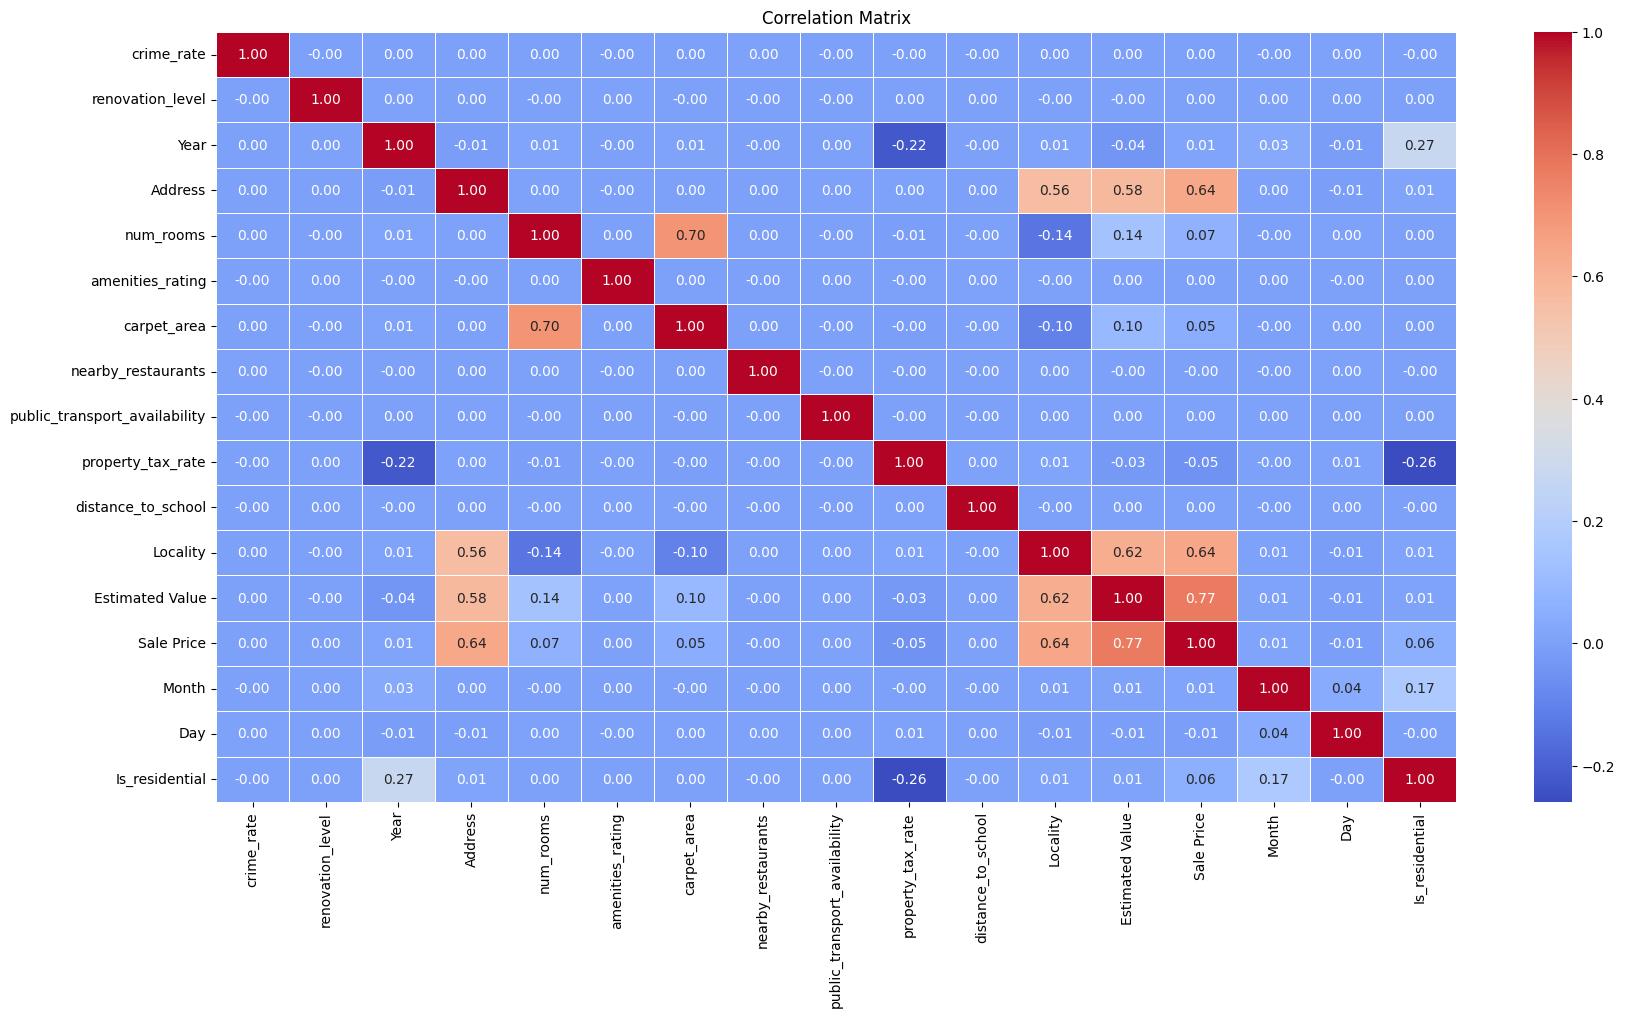

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_matrix = df.corr(method='spearman')

# Create a heatmap
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Predicting Test Set

In [62]:
tesdf = pd.read_csv('/kaggle/input/dataaa/pucon24-ai-test.csv')
tesdf

,Year,amenities_rating,public_transport_availability,Property,Locality,num_rooms,nearby_restaurants,Address,Date,Residential,renovation_level,property_tax_rate,crime_rate,distance_to_school,carpet_area,Segment,Estimated Value,Sale Price,specifications
0,2023,Satisfactory,Abundant,Residential,Old Lyme,Three rooms,20.0,12 SWAN AVE,2023-01-01-00:00:00,Detached House,Essential,1.46,3.3825675226607,2.215594,947.0,0,151400.0,0,"In 2023, this residential located in Old Lyme ..."
1,2023,Luxurious,Scattered,Residential,Ridgefield,Three rooms,11.0,59 LINCOLN LANE,2023-01-01-00:00:00,Detached House,Standard,1.46,9.36204013360774,5.898198,1051.0,0,686900.0,0,"In 2023, this residential located in Ridgefiel..."
2,2023,Superb,Insufficient,Residential,Cromwell,Three rooms,11.0,6 GROVE RD,2023-01-04-00:00:00,Detached House,Extensive,1.46,8.24743200094001,8.829687,925.0,0,152030.0,0,"In 2023, this residential located in Cromwell ..."
3,2023,Unimpressive,Limited,Residential,New Haven,Four rooms,8.0,346 CONCORD ST,2023-01-04-00:00:00,Duplex,Complete,1.46,1.5114243305380757,5.842769,1210.0,0,156130.0,0,"In 2023, this residential located in New Haven..."
4,2023,Satisfactory,Limited,Residential,Beacon Falls,Three rooms,5.0,14 LASKY ROAD,2023-01-04-00:00:00,Detached House,Minor,1.46,3.4527936889483795,2.598910,1089.0,0,108970.0,0,"In 2023, this residential located in Beacon Fa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43949,2023,Outstanding,Well-connected,Residential,Ansonia,Three rooms,7.0,22 FINNEY ST EXT,30-09-2023-00:00:00,Detached House,Minor,1.46,5.90726432876472,2.745719,1047.0,0,137600.0,0,"In 2023, this residential located in Ansonia a..."
43950,2023,Mediocre,Sparse,Residential,Enfield,Three rooms,9.0,26 GARY DR,2023-09-30-00:00:00,Detached House,Extensive,1.46,3.3074638296845813,4.363897,921.0,0,114650.0,0,"In 2023, this residential located in Enfield a..."
43951,2023,Satisfactory,Insufficient,Residential,Simsbury,Three rooms,9.0,72 PLANK HILL ROAD,30-09-2023-00:00:00,Detached House,Premium,1.46,NaN,1.223692,957.0,0,163400.0,0,"In 2023, this residential located in Simsbury ..."
43952,2023,Below Average,Scattered,Residential,Essex,Three rooms,4.0,12 BITTERSWEET LA,2023-09-30-00:00:00,Detached House,Premium,1.46,1.979080067587485,1.037037,1081.0,0,282300.0,0,"In 2023, this residential located in Essex at ..."


In [ ]:
tesdf.isna().sum()

In [64]:
tesdf['Date'] = pd.to_datetime(tesdf['Date'],format='mixed')

# Convert all dates back to the desired format (e.g., MM-DD-YYYY)
tesdf['Date'] = tesdf['Date'].dt.strftime('%m-%d-%Y')
tesdf['Date'] = pd.to_datetime(tesdf['Date'],format='mixed')
tesdf['Month'] = tesdf['Date'].dt.month
tesdf['Day'] = tesdf['Date'].dt.day
tesdf.replace('Not Provided', np.nan, inplace=True)

tesdf.isna().sum()

Year                                0
amenities_rating                    0
public_transport_availability       0
Property                            0
Locality                            0
num_rooms                           0
nearby_restaurants                  0
Address                             0
Date                                0
Residential                         0
renovation_level                    0
property_tax_rate                 877
crime_rate                       1722
distance_to_school                  0
carpet_area                       420
Segment                             0
Estimated Value                     0
Sale Price                          0
specifications                      0
Month                               0
Day                                 0
dtype: int64

In [65]:
tesdf['Is_residential']= np.where(tesdf['Property']=='Residential',1,0)
tesdf.drop(columns=['Property','specifications','Date','Residential'],inplace=True)

In [66]:
Seg = tesdf['Segment']
tesdf.drop(columns=['Segment'],inplace=True)
desired_column_order = ['crime_rate', 'renovation_level','Year', 'Address', 'num_rooms','amenities_rating','carpet_area','nearby_restaurants','public_transport_availability','property_tax_rate','distance_to_school','Locality','Estimated Value','Sale Price','Month','Day','Is_residential']  # Specify the desired column order

# Reorder the columns
tesdf = tesdf[desired_column_order]

In [67]:
tesdf['num_rooms'] = np.where(tesdf['num_rooms']=='Two rooms',2,tesdf['num_rooms'])
tesdf['num_rooms'] = np.where(tesdf['num_rooms']=='Three rooms',3,tesdf['num_rooms'])
tesdf['num_rooms'] = np.where(tesdf['num_rooms']=='Six rooms',6,tesdf['num_rooms'])
tesdf['num_rooms'] = np.where(tesdf['num_rooms']=='Four rooms',4,tesdf['num_rooms'])
tesdf['num_rooms'] = np.where(tesdf['num_rooms']=='Eight rooms',8,tesdf['num_rooms'])

tesdf['amenities_rating'] = np.where(tesdf['amenities_rating']=='Below Average',2,tesdf['amenities_rating'])
tesdf['amenities_rating'] = np.where(tesdf['amenities_rating']=='Marginal',1,tesdf['amenities_rating'])
tesdf['amenities_rating'] = np.where(tesdf['amenities_rating']=='Unimpressive',3,tesdf['amenities_rating'])
tesdf['amenities_rating'] = np.where(tesdf['amenities_rating']=='Commonplace',3,tesdf['amenities_rating'])
tesdf['amenities_rating'] = np.where(tesdf['amenities_rating']=='Mediocre',3,tesdf['amenities_rating'])
tesdf['amenities_rating'] = np.where(tesdf['amenities_rating']=='Satisfactory',4,tesdf['amenities_rating'])
tesdf['amenities_rating'] = np.where(tesdf['amenities_rating']=='Outstanding',5,tesdf['amenities_rating'])
tesdf['amenities_rating'] = np.where(tesdf['amenities_rating']=='Superb',5,tesdf['amenities_rating'])
tesdf['amenities_rating'] = np.where(tesdf['amenities_rating']=='Exceptional',5,tesdf['amenities_rating'])
tesdf['amenities_rating'] = np.where(tesdf['amenities_rating']=='Luxurious',6,tesdf['amenities_rating'])

tesdf['public_transport_availability'] = np.where(tesdf['public_transport_availability']=='Insufficient',1,tesdf['public_transport_availability'])
tesdf['public_transport_availability'] = np.where(tesdf['public_transport_availability']=='Inadequate',1,tesdf['public_transport_availability'])
tesdf['public_transport_availability'] = np.where(tesdf['public_transport_availability']=='Sparse',2,tesdf['public_transport_availability'])
tesdf['public_transport_availability'] = np.where(tesdf['public_transport_availability']=='Patchy',2,tesdf['public_transport_availability'])
tesdf['public_transport_availability'] = np.where(tesdf['public_transport_availability']=='Limited',2,tesdf['public_transport_availability'])
tesdf['public_transport_availability'] = np.where(tesdf['public_transport_availability']=='Scattered',2,tesdf['public_transport_availability'])
tesdf['public_transport_availability'] = np.where(tesdf['public_transport_availability']=='Accessible',3,tesdf['public_transport_availability'])
tesdf['public_transport_availability'] = np.where(tesdf['public_transport_availability']=='Well-connected',4,tesdf['public_transport_availability'])
tesdf['public_transport_availability'] = np.where(tesdf['public_transport_availability']=='Extensive',4,tesdf['public_transport_availability'])
tesdf['public_transport_availability'] = np.where(tesdf['public_transport_availability']=='Abundant',4,tesdf['public_transport_availability'])

tesdf['renovation_level'] = np.where(tesdf['renovation_level']=='Minor',1,tesdf['renovation_level'])
tesdf['renovation_level'] = np.where(tesdf['renovation_level']=='Essential',2,tesdf['renovation_level'])
tesdf['renovation_level'] = np.where(tesdf['renovation_level']=='Partial',3,tesdf['renovation_level'])
tesdf['renovation_level'] = np.where(tesdf['renovation_level']=='Limited',3,tesdf['renovation_level'])
tesdf['renovation_level'] = np.where(tesdf['renovation_level']=='Basic',4,tesdf['renovation_level'])
tesdf['renovation_level'] = np.where(tesdf['renovation_level']=='Standard',5,tesdf['renovation_level'])
tesdf['renovation_level'] = np.where(tesdf['renovation_level']=='Advanced',6,tesdf['renovation_level'])
tesdf['renovation_level'] = np.where(tesdf['renovation_level']=='Complete',7,tesdf['renovation_level'])
tesdf['renovation_level'] = np.where(tesdf['renovation_level']=='Extensive',7,tesdf['renovation_level'])
tesdf['renovation_level'] = np.where(tesdf['renovation_level']=='Premium',7,tesdf['renovation_level'])


In [68]:
tesdf['Locality'] = target_encoder1.transform(tesdf['Locality'])


In [69]:


def remove_numbers(address):
    return re.sub(r'\d+', '', address)
import re
# Apply the function to the 'Address' column
tesdf['Address'] = tesdf['Address'].apply(remove_numbers)
print(tesdf['Address'])

tesdf['Address'] = target_encoder.transform(tesdf['Address'])

0                SWAN AVE
1            LINCOLN LANE
2                GROVE RD
3              CONCORD ST
4              LASKY ROAD
               ...       
43949       FINNEY ST EXT
43950             GARY DR
43951     PLANK HILL ROAD
43952      BITTERSWEET LA
43953            WEST AVE
Name: Address, Length: 43954, dtype: object


In [70]:

tesdfx = imputer.transform(tesdf)

# Convert the result back to a DataFrame
tesdf = pd.DataFrame(tesdfx, columns=tesdf.columns)
tesdf

,crime_rate,renovation_level,Year,Address,num_rooms,amenities_rating,carpet_area,nearby_restaurants,public_transport_availability,property_tax_rate,distance_to_school,Locality,Estimated Value,Sale Price,Month,Day,Is_residential
0,3.382568,2.0,2023.0,223342.649746,3.0,4.0,947.0,20.0,4.0,1.46,2.215594,404901.346719,151400.0,0.0,1.0,1.0,1.0
1,9.362040,5.0,2023.0,367585.296813,3.0,6.0,1051.0,11.0,2.0,1.46,5.898198,698158.052632,686900.0,0.0,1.0,1.0,1.0
2,8.247432,7.0,2023.0,215718.870913,3.0,5.0,925.0,11.0,1.0,1.46,8.829687,233975.149597,152030.0,0.0,1.0,4.0,1.0
3,1.511424,7.0,2023.0,174422.155521,4.0,3.0,1210.0,8.0,2.0,1.46,5.842769,201420.601495,156130.0,0.0,1.0,4.0,1.0
4,3.452794,1.0,2023.0,331336.299109,3.0,4.0,1089.0,5.0,2.0,1.46,2.598910,266655.723636,108970.0,0.0,1.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43949,5.907264,1.0,2023.0,327813.172275,3.0,5.0,1047.0,7.0,4.0,1.46,2.745719,181830.964560,137600.0,0.0,9.0,30.0,1.0
43950,3.307464,7.0,2023.0,296806.817962,3.0,3.0,921.0,9.0,2.0,1.46,4.363897,179408.837994,114650.0,0.0,9.0,30.0,1.0
43951,5.360850,7.0,2023.0,332886.683607,3.0,4.0,957.0,9.0,1.0,1.46,1.223692,326509.087512,163400.0,0.0,9.0,30.0,1.0
43952,1.979080,7.0,2023.0,363309.301662,3.0,2.0,1081.0,4.0,2.0,1.46,1.037037,467326.836986,282300.0,0.0,9.0,30.0,1.0


In [ ]:
tes = tesdf[['crime_rate',
        'carpet_area',
       'distance_to_school', 'Locality', 'Estimated Value',
       'Month']]
y_pred = lgbm_regressor.predict(X_test)


# Autogluon didnt work well too

In [ ]:
!pip install autogluon


In [ ]:
!pip install --upgrade autogluon


In [ ]:
from autogluon.tabular import TabularPredictor

# Create a TabularPredictor


# Train the model on the training set
predictor = TabularPredictor(label='Sale Price', problem_type='regression', eval_metric='mean_squared_error')
predictor.fit(X_train,time_limit=300)

# Make predictions on the test set
y_pred = predictor.predict(X_test)



# Submission

In [ ]:
qq = pd.DataFrame()
qq['tes'] = y_pred
ans  = (qq['tes']-tesdf['Estimated Value'])/100
sorted_column = ans.sort_values()
# Determine quartiles
q1 = sorted_column.quantile(0.25)
q2 = sorted_column.quantile(0.5)
q3 = sorted_column.quantile(0.75)
qq['Segment'] = np.where(ans>q3,'Segment 0','none')
qq['Segment'] = np.where((ans>q2) & (ans<=q3),'Segment 1',qq['Segment'])
qq['Segment'] = np.where((ans>q1) & (ans<=q2),'Segment 2',qq['Segment'])
qq['Segment'] = np.where(ans<=q1,'Segment 3',qq['Segment'])
qq['Segment'].astype(int)
qq.drop(columns=['tes'],inplace=True)
qq.to_csv('submission.csv',index=True)
import csv

# Assuming df is your DataFrame
with open('test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(qq.columns)  # Write column names
    for row in qq.values:
        writer.writerow(row)